    Who are the suppliers and recipients of major conventional weapons?
    What weapons have been exported or imported by specific suppliers or recipients?
    How have the relationships between different suppliers and recipients changed over time?
    Where do countries in conflict get their weapons from?
    How do states implement their export control regulations?
    Where are potentially destabilizing build ups of weapons occurring?
    What is the relationship between access to natural resources and arms transfers?

In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import operator
import matplotlib.pyplot as plt
import community
%matplotlib inline  
import plotly
from plotly.graph_objs import *
import plotly.plotly as py


In [2]:
import copy

# 1) Importing and linking the data

## 1.1) Reading the CSV files into seperate clean panda dataframes

In [3]:
def loadTable(directory, country_code):
    path = directory+'TIV-Import-'+country_code+'-1950-2015.csv'
    df = pd.read_csv(path)
    
    #extract current country
    to_country = df.columns.values.tolist()[0].split('TIV of arms exports to ')[1].split(', 1950-2015')[0]
    
    #downsize
    df = df.ix[9:]
    
    #get rid of column
    df = df.drop(df.columns[[0]],axis =1)
    df.columns = df.iloc[0]
    df.columns.values[0] = 'country'
    df = df.set_index((df['country']))
    df = df.drop(df.columns[0], axis=1)
    
    #take the data less the header row
    df = df[1:] 
    df.index.name = None #credit to ulynn
    df.columns.name = None
    
    # Format of the keys should be YEAR - COUNTRYFROM - COUNTRYTO --> Faster query over the years
    try:
        df.columns = df.columns.astype('string').str.replace('\.0','')
    except:
        df.columns = df.columns.astype('str').str.replace('\.0','')
        
    df.fillna(0, inplace=True)
    try:
        df.drop(df.loc['Unknown country'].name,inplace=True)
    except:
        ""
        #print "UNSUCCESSFUL DROP:",'Unknown country'
        
    #last cleansing
    df.drop(df.index[[-1,-2]],inplace=True)
    df.drop(df.columns[-1], axis=1,inplace=True)

    return df, to_country

## 1.2) Convert one pandas dataframe into a structured dict

In [4]:
#FORMAT
#[YEARS][FROM][TO] = MONEY
def convertTableToDict(df, onecountrydict, countryTo):
    years = list(df.columns.values)
    listofcountries = list(df.index)

    for y in range(0,len(years)):
        year = years[y]
        onecountrydict.setdefault(year, dict())
        onecountrydict[year].setdefault(countryTo, dict())
        
        for country in range(0,len(listofcountries)):
            countryFrom = listofcountries[country]
            value = df.get_value(countryFrom, year)
            onecountrydict[year][countryTo].setdefault(countryFrom, value)
            #onecountrydict[year][countryTo].setdefault("Total", 0)
            #onecountrydict[year][countryTo]["Total"] += value
            
    return onecountrydict

In [5]:
#delete empty cells from dict

def clean_empty(d):
    if not isinstance(d, (dict, list)):
        return d
    if isinstance(d, list):
        return [v for v in (clean_empty(v) for v in d) if v]
    return {k: v for k, v in ((k, clean_empty(v)) for k, v in d.items()) if v}

In [6]:
countryImportDict = dict()
PATH = '/Users/hai/Devproj/weaponstradeanalysis/data/'

countryCodeMap = dict()

for f in os.listdir(PATH):
    if not f.startswith('.'):
        if "country_codes.csv" not in f:
            countryCode = f.replace('TIV-Import-',"").replace('-1950-2015.csv', "")
            df,to_country = loadTable(PATH, countryCode)
            countryImportDict = convertTableToDict(df, countryImportDict, to_country)
            countryCodeMap.setdefault(to_country, countryCode)

countryImportDict = clean_empty(countryImportDict)

MultiDiDict = dict()
for year in countryImportDict:
    MultiDiDict.setdefault(year, dict())
    for countryImport in countryImportDict[year]:
        for countryExport in countryImportDict[year][countryImport]:
            MultiDiDict[year].setdefault(countryExport, dict())
            MultiDiDict[year][countryExport].setdefault(countryImport, 0)
            MultiDiDict[year][countryExport][countryImport] += countryImportDict[year][countryImport][countryExport]

In [7]:
df = pd.DataFrame.from_dict(countryCodeMap, orient="index")
df.sort_index(inplace=True)
df.to_csv('countrymap.csv')


In [8]:
CompleteDict = copy.deepcopy(MultiDiDict)

## Analysis function

In [9]:
def createNeighbourGraph(G, node):
    
    newGraph = nx.Graph()
    
    for edge in G.edges(data=True):
        if edge[0] == node or edge[1] == node:
            newGraph.add_edge(edge[0],edge[1],edge[2])
    
    return newGraph

In [10]:
def addUpDict(MasterDict):

    SomethingsOverwrittenDict = MasterDict

    AddedUpDict = dict()

    for year in SomethingsOverwrittenDict:
        AddedUpDict.setdefault(year, dict())
        for countryExport in SomethingsOverwrittenDict[year]:
            for countryImport in SomethingsOverwrittenDict[year][countryExport]:
                AddedUpDict[year].setdefault(countryExport, dict())
                AddedUpDict[year][countryExport].setdefault(countryImport, 0)
                Richtung = SomethingsOverwrittenDict[year][countryExport][countryImport]
                #andere richtung verfügbar?
                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        andereRichtung = SomethingsOverwrittenDict[year][countryImport][countryExport]
                    else: andereRichtung = 0
                else: andereRichtung = 0
                
                #Transmitting stuff into the AddedUpDict
                if (Richtung + andereRichtung) != 0:
                    AddedUpDict[year][countryExport][countryImport] = Richtung + andereRichtung

                #"Clearing the MasterDict"
                SomethingsOverwrittenDict[year][countryExport][countryImport] = 0

                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        SomethingsOverwrittenDict[year][countryImport][countryExport] = 0
    
    return AddedUpDict

In [11]:
def createYearGraph(AddedUpDict, year):
    
    G = nx.Graph()
    year = year
    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    return G

In [12]:
def createYearMultiDiGraph(AddedUpDict, year):
    
    G = nx.MultiDiGraph()
    year = year
    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    return G

In [13]:
AddedUpDict = addUpDict(MultiDiDict)
AddedUpDict = clean_empty(AddedUpDict)

mastergraph = createYearGraph(AddedUpDict, '1960')

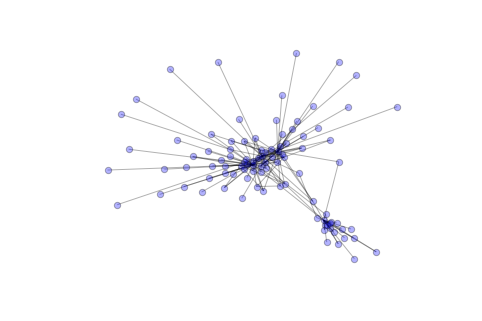

In [14]:
plt.gcf().clear()
nx.draw(mastergraph,node_size=40, alpha=0.3, node_color="blue", with_labels=False)
plt.show()
plt.rcParams['figure.figsize'] = (9, 9)

In [15]:
sorted(nx.pagerank_numpy(mastergraph).items(), key=operator.itemgetter(1), reverse=True)[:10]

[('United States', 0.2058827441745041),
 ('Soviet Union', 0.10335243107457322),
 ('United Kingdom', 0.08401764928272469),
 ('Germany (FRG)', 0.06642774180127158),
 ('France', 0.05371137463936625),
 ('China', 0.03492772807414171),
 ('Japan', 0.026246801014696904),
 ('Switzerland', 0.021170222074970234),
 ('India', 0.019408049392894755),
 ('Turkey', 0.018465300952745494)]

In [16]:
data = pd.DataFrame(sorted(nx.betweenness_centrality(mastergraph).items(), key=operator.itemgetter(1), reverse=True)[:10])
data.columns = ['country','betweenness centrality']

In [17]:
from bokeh.charts import Bar, output_notebook, show
output_notebook()

p = Bar(data, 'country', values='betweenness centrality', title="betweenness centrality in "+year,color='country', legend=None)

show(p)

Loading BokehJS ...

In [18]:
#nx.draw_networkx(mastergraph, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

In [19]:
"""G = mastergraph
pos=nx.spring_layout(G)
""";

In [20]:
"""edge_trace = []

for edge in G.edges(data=True):
    countryFrom = edge[0]
    countryTo = edge[1]
    x0, y0 = pos[countryFrom]
    x1, y1 = pos[countryTo]

    edge_trace.append(
        Scatter(
            x=[x0, x1, None], 
            y=[y0, y1, None], 
            #text=[edge[2].values()[0]],
            text='skip',
            line=Line(width = (edge[2].values()[0]/100),
                      color ='#888'
                     ),
            #hoverinfo=edge[2].values()[0],
            hoverinfo='none',
            mode='lines'
        )
    )
""";

In [21]:
"""node_trace = Scatter(
    x=[], 
    y=[], 
    text=[],
    mode='markers', 
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIOrRd',
        reversescale=True,
        color=[], 
        size=10,         
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_trace['text'].append(str(countryCodeMap[node]))
    
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))    
""";

In [22]:
"""
fig = Figure(data=Data(edge_trace+[node_trace]),
             layout=Layout(
                title='The Worlds Weapon Trade',
                titlefont=dict(size=16),
                showlegend=False, 
                width=650,
                height=650,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Datasource: SIPRI",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False))
            )

#py.iplot(fig, filename='weaponstrade')
""";


# K-Means

## Cluster the nodes

http://scikit-learn.org/stable/modules/clustering.html

In [23]:
#from sklearn.cluster import KMeans

In [24]:
#posdf = pd.DataFrame()
#posdf = posdf.from_dict(pos)
#posdf = posdf.transpose()

In [25]:
"""reduced_data = posdf.values
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)""";

In [26]:
"""#Visualization from Here http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()""";

TIL kmeans is a shitty algorithm, since it only takes X and Y into account, not good for graphs

# Clustering using the louvain method

It uses the louvain method described in Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp)

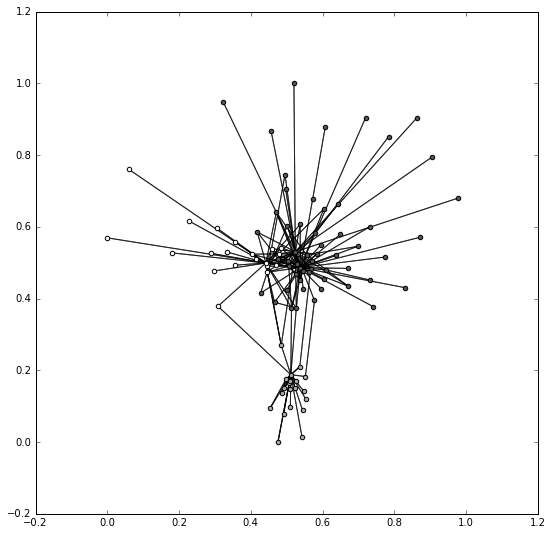

In [27]:
G = mastergraph

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
    nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

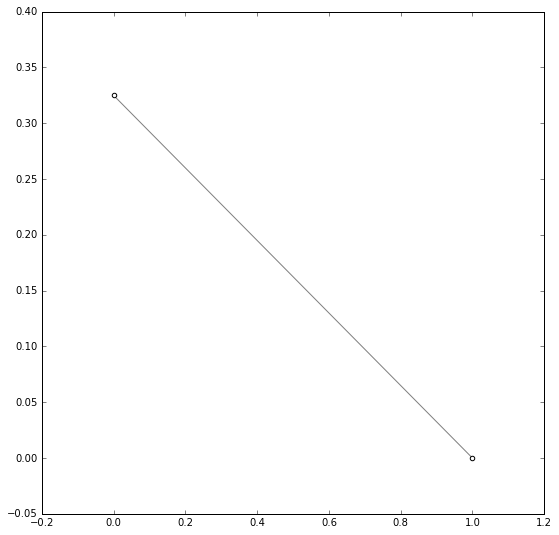

In [28]:
n = (G.number_of_nodes())/2 
part = dict([])
for node in G.nodes():
    part[node] = node
ind = community.induced_graph(part, G)
goal = nx.Graph()
goal.add_weighted_edges_from([(0,1,n*n),(0,0,n*(n-1)/2), (1, 1, n*(n-1)/2)])  # NOQA

#drawing
partition = community.best_partition(goal)
size = float(len(set(partition.values())))
pos = nx.spring_layout(goal)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(goal, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
    nx.draw_networkx_edges(goal,pos, alpha=0.5)
plt.show()

In [29]:
colormap = dict([(0, 'rgb(91,147,204)'), (1, 'rgb(255,46,43)'),(2, 'rgb(145,58,31)'), (3, 'rgb(151,219,79)'), (4, 'rgb(41,255,25)'), (5, 'rgb(255,104,0)'), (6, 'rgb(44,20,204)'), (7, 'rgb(178,84,18)')])

In [30]:
pos3=nx.spring_layout(mastergraph, dim=3)

In [31]:
trace1 = []
for edge in G.edges(data=True):
    trace1.append(
        Scatter3d(x=[pos3[edge[0]][0],pos3[edge[1]][0], None],
                  y=[pos3[edge[0]][1],pos3[edge[1]][1], None],
                   z=[pos3[edge[0]][2],pos3[edge[1]][2], None],
                   mode='lines',
                   line=Line(color='rgb(125,125,125)',
                             width=(np.log(edge[2].values()[0])),
                             colorscale = 'Bluered'),
                   hoverinfo='none',
                   opacity=0.7
                   )
        )

trace2 = []
for node in G.nodes():
    totaltrade = 0
    for edge in G.edges(data=True):
        if edge[0] == node or edge[1] == node:
            totaltrade += edge[2].values()[0]
            
    trace2.append(
        Scatter3d(x=pos3[node][0],
                  y=pos3[node][1],
                   z=pos3[node][2],
                   mode='markers',
                   name='Country',
                   marker=Marker(symbol='dot',
                                 size=np.log(totaltrade),
                                 #color=partition[node],
                                 color=colormap[partition[node]],
                                 showscale=False,
                                 cmin = 0,
                                 cmax = 4,
                                    # colorscale options
                                    # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
                                    # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
                                 colorscale='Electric',
                                 line=Line(color='rgb(50,50,50)', width=0.5)                                 ),
                   #text=str(countryCodeMap[node]),
                   text=str(node),
                   hoverinfo='text',
                   opacity=0.7
                   )
        )

KeyError: 'Canada'

In [ ]:
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=True,
          showticklabels=False,
          title=''
          )

In [ ]:
layout = Layout(
         title="Global Weapontrade",
         width=800,
         height=800,
         showlegend=False,
         scene=Scene(
             xaxis=XAxis(axis),
             yaxis=YAxis(axis),
             zaxis=ZAxis(axis),
        ),
    margin=Margin(
        t=100
    ),
    hovermode='closest',
    annotations=Annotations([
           Annotation(
           showarrow=False,
            text="SIPRI",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=Font(
                size=14
            )
            )
        ]),
)


In [ ]:
#data=Data(trace1+trace2)
#fig=Figure(data=data, layout=layout)

#py.iplot(fig, filename='Weapontrade')

In [ ]:
print nx.info(G)

In [ ]:
test = createNeighbourGraph(G, 'Saudi Arabia')

In [ ]:
plt.gcf().clear()
nx.draw(test,node_size=40, alpha=0.3, node_color="blue", with_labels=True)
plt.show()
plt.rcParams['figure.figsize'] = (9, 9)

In [ ]:
completeGraph = createYearMultiDiGraph(CompleteDict, '1990')

In [ ]:
plt.gcf().clear()
nx.draw(completeGraph,node_size=40, alpha=0.3, node_color="blue", with_labels=False)
plt.show()
plt.rcParams['figure.figsize'] = (9, 9)

In [ ]:
#completeGraph.edges(data = True)

In [ ]:
## Analyze countries influence over time

def influenceOverTime(countrydict,country):
    influence = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year)
        valuethisyear = 0
        for entry in nx.betweenness_centrality(G).items():
            if entry[0] == country:
                valuethisyear = entry[1]
        influence[year] = valuethisyear
    return influence

# Influence Analysis

In [ ]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import output_notebook

from bokeh.models import ColumnDataSource,HoverTool
output_notebook()

In [ ]:
def influenceOverTimeAll(countrydict):
    influenceAll = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year)
        for entry in nx.betweenness_centrality(G).items():
            if entry[0] in influenceAll:
                influenceAll[entry[0]][year] = entry[1]
            else:
                influenceAll.setdefault(entry[0], dict())
                influenceAll[entry[0]][year] = entry[1]
    return influenceAll

In [ ]:
def generateInfluenceTimelines(plot,influencedict, countries):
    from bokeh.palettes import Spectral10
    d = dict(x=[], y=[],country=[], color=[])
    color = copy.copy(Spectral10)
    for country in countries:
        countrycolor = color[0]
        color.remove(countrycolor)
        line = dict(xe=[], ye=[])
        for entry in sorted(influencedict[country].items(), key=operator.itemgetter(0)):
            d['x'].append(entry[0])
            d['y'].append(entry[1])
            d['country'].append(country)
            d['color'].append(countrycolor)
            line['xe'].append(entry[0])
            line['ye'].append(entry[1])
        plot.line(line['xe'], line['ye'], color=countrycolor)
    
    s1 = plot.scatter('x', 'y', line_width=1, color = 'color', source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('y','@y'),
                                                    ('year','@x'),
                                                    ('country','@country')]))

    return plot

In [ ]:
influencedict = influenceOverTimeAll(AddedUpDict)


plot = figure(plot_width=600, plot_height=400, tools=['pan','tap','box_zoom','reset','wheel_zoom'])

countriestoanalyze = ['Canada', 'United States', 'China']

plot = generateInfluenceTimelines(plot,influencedict,countriestoanalyze)


In [ ]:
plot.yaxis.bounds = [0,1]
plot.xaxis.bounds = [1950,2015]
plot.x_range.start =1950
plot.x_range.end =2015
plot.y_range.start =0
plot.y_range.end =1
show(plot)


## New Visualization

In [ ]:
from math import sqrt
from bokeh.models import ColumnDataSource

In [ ]:
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from bokeh.models import HoverTool

output_notebook()
layout = nx.spring_layout(G,iterations = 100)

In [ ]:
def get_nodes_specs(_network, _layout):
    d = dict(x=[], y=[], color=[], country=[], size=[], totaltrade =[], cluster=[], alpha=[], largestpartner=[])
    
    for node in _network.nodes():
        totaltrade = 0
        largest_trade_partner_trade = 0
        largest_trade_partner_name = ''  
        
        for edge in G.edges(data=True):
                if edge[0] == node or edge[1] == node:
                    totaltrade += edge[2].values()[0]
                    if edge[2].values()[0] >= largest_trade_partner_trade:
                        largest_trade_partner_trade = edge[2].values()[0]
                        if edge[0] == node:
                            largest_trade_partner_name = edge[1]
                        else:
                            largest_trade_partner_name = edge[0] 

        d['x'].append(_layout[node][0])
        d['y'].append(_layout[node][1])
        d['color'].append(colormap[partition[node]])
        d['country'].append(node)
        d['size'].append(np.log(totaltrade))
        d['totaltrade'].append(totaltrade)
        d['cluster'].append(partition[node])
        d['alpha'].append(0.7)
        d['largestpartner'].append(largest_trade_partner_name)
    return d

In [ ]:
def get_edges_specs(_network, _layout):
    d = dict(xs=[], ys=[], alphas=[], width=[])
    weights = []
    for u, v, data in _network.edges(data=True):
        weights.append(data)
    max_weight = max(weights).values()
    calc_alpha = lambda h: 0.1 + 0.6 * (h / max_weight)
    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
        d['width'].append(np.log(data.values()[0]))
    
    return d

In [ ]:
hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('total trade','@totaltrade'),
                            ('largest tradepartner', '@largestpartner')])

plot = figure(plot_width=600, plot_height=400, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom'])

r_circles = plot.circle('x','y', source=ColumnDataSource(get_nodes_specs(G, layout)), size='size', color='color', level='overlay')
r_lines = plot.multi_line('xs', 'ys', line_width='width', alpha='alphas', color='navy', source=ColumnDataSource(get_edges_specs(G, layout)))


In [ ]:
show(plot)

In [ ]:
centrality =\
    nx.algorithms.centrality.betweenness_centrality(G)
# first element are nodes again
_, nodes_centrality = zip(*sorted(centrality.items()))
max_centraliy = max(nodes_centrality)
nodes_source.add([7 + 10 * t / max_centraliy
                  for t in nodes_centrality],
                 'centrality')

In [ ]:
partition = community.best_partition(G)
p_, nodes_community = zip(*sorted(partition.items()))
nodes_source.add(nodes_community, 'community')
community_colors = ['#e41a1c','#377eb8', '#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628', '#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
nodes_source.add([community_colors[t % len(community_colors)]
                  for t in nodes_community],
                 'community_color')

In [ ]:
r_circles.glyph.size = 'centrality'
r_circles.glyph.fill_color = 'community_color'

In [ ]:
ColumnDataSource.selected
{
 # line or patch glyph selections
 '0d': {'get_view': {}, 'glyph': None,
        'indices': []},
 # all other glyph selections
 '1d': {'indices': [73]},
 # [multi]line or patch selections
 '2d': {'indices': []}
}

In [ ]:
def remove_node():
    idx = nodes_source.selected['1d']['indices'][0]
    
    # update networkX network
    node = nodes_source.data['name'][idx]
    G.remove_node(node)
    
    # update layout
    layout.pop(node)
    
    # update nodes ColumnDataSource
    new_source_data = dict()
    for column in nodes_source.column_names:
        new_source_data[column] =\
        [e for i, e in enumerate(nodes_source.data[column])
         if i != idx]
    nodes_source.data = new_source_data

    # update lines ColumnDataSource
    lines_source.data = get_edges_specs(G, layout)

In [ ]:
# analyze weapon trade before/during/after conflict
# weapon flow democratic vs republican leadership #germany
